# Estimate shoaling of CDW isopycnals in the 1000 m isobath

In [1]:
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [3]:
client = Client(threads_per_worker = 1)

## Part 1 - Monthly data evaluation

In [4]:
#volume timeseries
volume_percentage = xr.open_dataset('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/percentage_of_CDW.nc')



In [ ]:
#importing CSHT for calculation of bins
CSHT_along = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12}).isel(time=0).drop('time')

In [5]:
def binning_age_3deg(CSHT_along, age_sigma, vol_sigma, CSHT_for_3degbinning):
    
    #binning into 3deg
    bin_width = 3
    bin_spacing = 0.25
    lon_west = -280
    lon_east = 80
    
    # new coordinate and midpoints of longitude bins:
    full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
    lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
    
    n_bin_edges = len(full_lon_coord)
    lon_along_contour = np.array(CSHT_along.lon_along_contour)
    lat_along_contour = np.array(CSHT_along.lat_along_contour)
    
    
    bin_edge_indices = np.zeros(n_bin_edges)
    for lon_bin in range(n_bin_edges-1):
        # find first isobath point that has the right longitude:
        first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
        # then find all other isobath points with the same longitude as that first point:
        same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
        # we want the most southerly of these points on the same longitude line:
        bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
        
    # define east/west edges:
    bin_edge_indices = bin_edge_indices.astype(int)
    bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
    bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
    n_bins = len(bin_edge_indices_west)
    
    
    lat_bin_midpoints = np.zeros(n_bins)
    for lon_bin in range(n_bins):
        # find nearest isobath point:
        lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
        lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
    
    
    #averaging the age along the contour, in sigma bins
    age_sigma = age_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
    vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
    
    age_contour_3deg = np.zeros([age_sigma.shape[0],108,n_bins])*np.nan
    for lon_bin in range(n_bins):
        age_contour_3deg0 = age_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        distance_along0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        #making sure we only have distances where there are values
        distance_along0 = ((age_contour_3deg0 *0)+1) *distance_along0
        age_contour_3deg[:,:,lon_bin] = (np.nansum(age_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))
    
    #removing zeros
    age_contour_3degnp = np.where(age_contour_3deg!=0,age_contour_3deg,np.nan)
    
    
    #ages
    age_contour_3deg = CSHT_for_3degbinning.binned_cross_slope_heat_trans.copy()
    age_contour_3deg.name = 'age'
    age_contour_3deg.values = age_contour_3degnp
    
    vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
    
    vol_contour_3deg = np.zeros([age_sigma.shape[0],108,n_bins])*np.nan
    for lon_bin in range(n_bins):
        vol_contour_3deg0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        vol_contour_3deg[:,:,lon_bin] = (np.nansum(vol_contour_3deg0,axis=2))
    
    #removing zeros
    vol_contour_3degnp = np.where(vol_contour_3deg!=0,vol_contour_3deg,np.nan)
    
    #volumes_rho
    vol_contour_3deg = CSHT_for_3degbinning.binned_cross_slope_heat_trans.copy()
    vol_contour_3deg.name = 'Volume'
    vol_contour_3deg.values = vol_contour_3degnp
    
    
    return age_contour_3deg, vol_contour_3deg

In [7]:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')

In [8]:
# monthly water mass mask 
CDW_age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/CDW_age_mask.nc').CDW_mask

In [119]:
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc')
mean_u_CDW = (u_along.U*CDW_age_mask*vol_bins.volume).sum('potrho0')/(CDW_age_mask*vol_bins.volume).sum('potrho0')
mean_u_CDW['lon_bins'] = CDW_meandens.lon_bins
mean_u_CDW['time'] = CDW_meandens.time
mean_u_CDW.load()
print('loaded mean U at CDW layer')

loaded mean U at CDW layer


In [6]:
Volume_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/volume_daily_10deg/OM2_01_iaf_cycle3/VOL*.nc')

In [9]:
#minimum and maximum density of CDW 
CDW_mindens = (CDW_age_mask.where(CDW_age_mask>0) *CDW_age_mask.potrho0).min('potrho0').compute()
CDW_meandens = (CDW_age_mask.where(CDW_age_mask>0) *CDW_age_mask.potrho0).mean('potrho0').compute()

In [10]:
#importing sigma_0 along contour
σ0_iaf_monthly_along_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/T_Sigma_along_contour/potrho0_along_contour.nc').pot_rho_0
T_iaf_monthly_along_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/T_Sigma_along_contour/T_along_contour.nc').temp

#creating bin edges for 10-deg bins
lon_edges_west_forT = np.array(CSHT_along.lon_bins-5)
lon_edges_east_forT = np.array(CSHT_along.lon_bins+5)
lon_edges_forT = np.append(lon_edges_west_forT,lon_edges_east_forT[-1])
lon_edges_forT[0]=-282
lon_edges_forT[-1]=82
# binned density in 10 degrees bins
σ0_iaf_monthly_along_contour_10_deg = σ0_iaf_monthly_along_contour.groupby_bins("xt_ocean",lon_edges_forT).mean() - 1000
σ0_iaf_monthly_along_contour_10_deg=σ0_iaf_monthly_along_contour_10_deg.rename({'xt_ocean_bins':'lon_bins'})
σ0_iaf_monthly_along_contour_10_deg['lon_bins'] = CDW_meandens.lon_bins
σ0_iaf_monthly_along_contour_10_deg['time'] = CDW_meandens.time


# binned temp in 10 degrees bins
T_iaf_monthly_along_contour_10_deg = T_iaf_monthly_along_contour.groupby_bins("xt_ocean",lon_edges_forT).mean()
T_iaf_monthly_along_contour_10_deg=T_iaf_monthly_along_contour_10_deg.rename({'xt_ocean_bins':'lon_bins'})
T_iaf_monthly_along_contour_10_deg['lon_bins'] = CDW_meandens.lon_bins
T_iaf_monthly_along_contour_10_deg['time'] = CDW_meandens.time

**Let's now locate the CDW density bins in the $\sigma(z)$ values along the contour**

First for the mean CDW depth

In [11]:
sigma = σ0_iaf_monthly_along_contour_10_deg.copy()
cdw   = CDW_meandens.copy()

# step 1: align CDW to sigma shape by expanding over st_ocean
cdw_expanded = cdw.expand_dims(st_ocean=sigma.st_ocean)

# step 2: compute absolute difference
diff = np.abs(sigma - cdw_expanded)


# step 3: find index of minimum along st_ocean
st_idx = diff.argmin(dim="st_ocean")

# get the actual st_ocean coordinate instead of index
mean_CDW_depth = sigma.st_ocean.isel(st_ocean=st_idx)



### variability monthly  ########################################################
# range of mean CDW depth=
range_mean_CDW_depth = mean_CDW_depth.max('time') - mean_CDW_depth.min('time')
# Standard deviation of mean
SD_mean_CDW_depth = mean_CDW_depth.std('time')

### Annual variability ########################################################
# range of annual mean CDW depth=
range_annualmean_CDW_depth = mean_CDW_depth.groupby('time.year').mean().max('year') - mean_CDW_depth.groupby('time.year').mean().min('year')
# # Standard deviation of annual mean
SD_annualmean_CDW_depth = mean_CDW_depth.groupby('time.year').mean().std('year')

now with the minimum CDW depth

In [12]:
sigma = σ0_iaf_monthly_along_contour_10_deg.copy()
cdw   = CDW_mindens.copy()

# step 1: align CDW to sigma shape by expanding over st_ocean
cdw_expanded = cdw.expand_dims(st_ocean=sigma.st_ocean)

# step 2: compute absolute difference
diff = np.abs(sigma - cdw_expanded)


# step 3: find index of minimum along st_ocean
st_idx = diff.argmin(dim="st_ocean")

# get the actual st_ocean coordinate instead of index
min_CDW_depth = sigma.st_ocean.isel(st_ocean=st_idx)


### variability monthly  ########################################################
# range of mean CDW depth=
range_min_CDW_depth = min_CDW_depth.max('time') - min_CDW_depth.min('time')
# Standard deviation of mean
SD_min_CDW_depth = min_CDW_depth.std('time')

### Annual variability ########################################################
# range of annual mean CDW depth=
range_annualmin_CDW_depth = min_CDW_depth.groupby('time.year').mean().max('year') - min_CDW_depth.groupby('time.year').mean().min('year')
# # Standard deviation of annual mean
SD_annualmin_CDW_depth = min_CDW_depth.groupby('time.year').mean().std('year')

Importing correlations to compare with the CDW depth variability

In [13]:
files_path = '/g/data/ik11/users/wf4500/ASC_project_files/' # 10deg
file_extension = 'agemaskCDW_volav'
file_extension_daily_clima = 'agemaskCDW_daily'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '_corr.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins_' + file_extension + '_corr.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()


ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
r_sq_daily_10deg = ds.r_sq_clim
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_APR10_noZC.nc')
r_sq_daily_10deg_noZC = ds.r_sq_clim
ds.close()


ds = xr.open_dataset(files_path + 'slope_annual_10degBins_' + file_extension + '_corr.nc')
slope_sq_annual_10deg = ds.slope_annual
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_10degBins_' + file_extension + '_corr.nc')
slope_sq_all_10deg = ds.slope_all
ds.close()

ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
slope_sq_daily_10deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '_APR10_noZC.nc')
slope_sq_daily_10deg_noZC = ds.slope_clima
ds.close()

In [14]:
longitude_inds = np.array([5,36-15, 14, 3,10,17,36-12,36-10, 36-1,1])
regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
           'Glomar', 'Amundsen', 'Filchner', \
           'Riiser-Larsen', 'Amery', 'Denman']

In [15]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

(0.0, 1200.0)

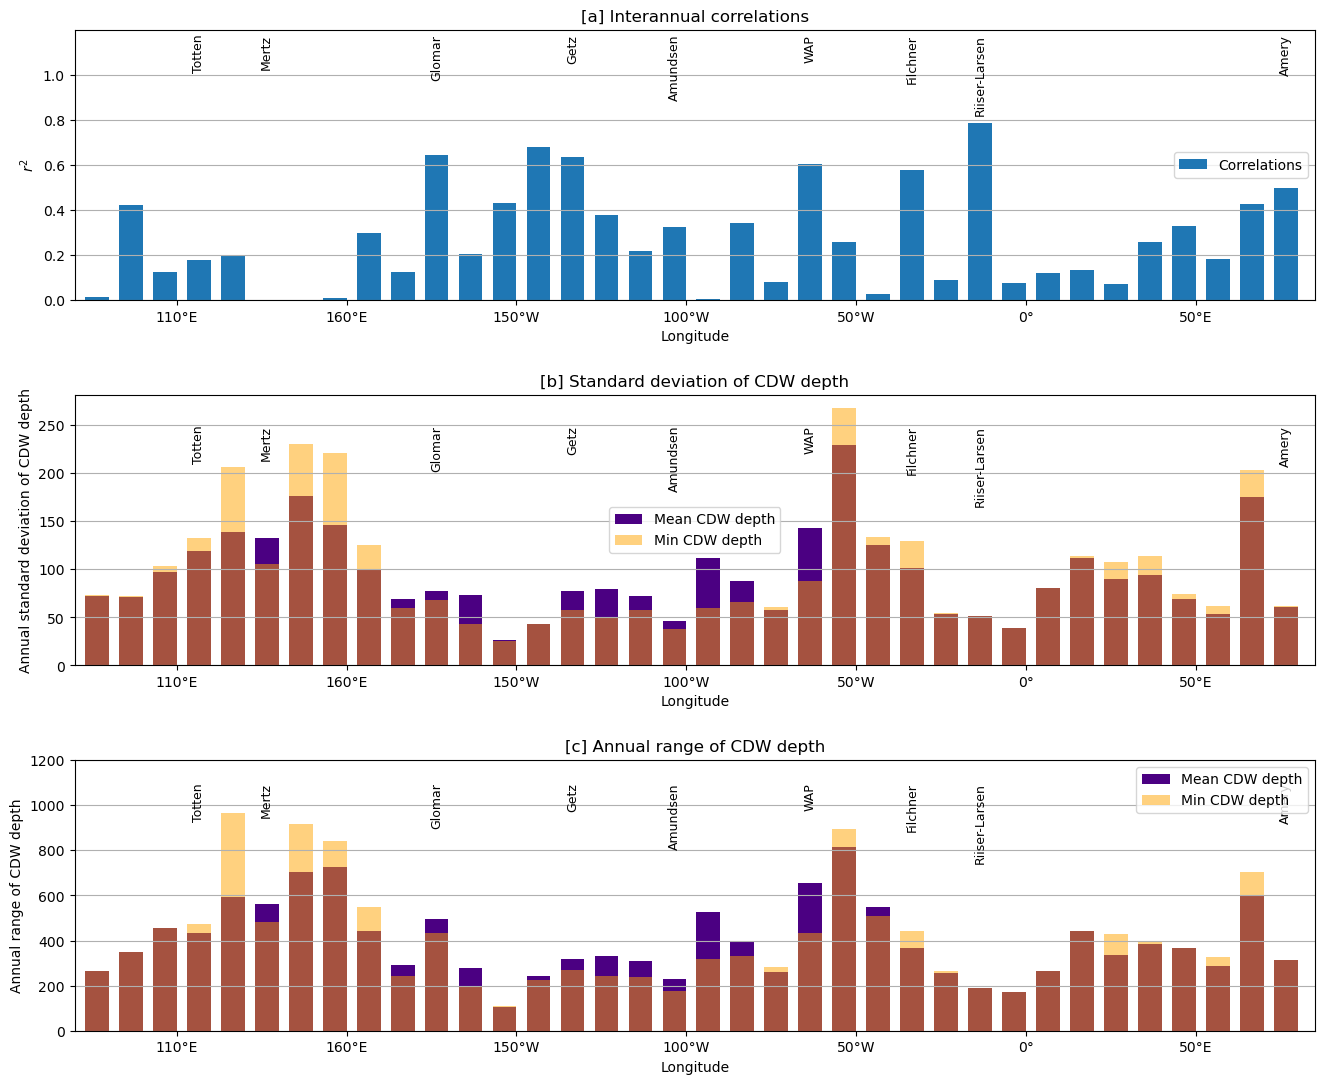

In [16]:
plt.figure(figsize=(16,13))
plt.subplots_adjust( hspace=.35)
#fig,ax_cric = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5))

ax_cric0 = plt.subplot(3,1,1)
#r_sq_annual_10deg.to_series().plot.bar(label='With zonal convergence')
plt.bar(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg,width=7,label='Correlations')
plt.legend()
plt.grid(axis='y')
plt.ylabel('$r^2$')
plt.ylim(0,1.2)
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 1.18, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.title('[a] Interannual correlations')
plt.yticks([0,.2,.4,.6,.8,1])
plt.xlim(-280,85)
ax_cric0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')

ax_cric1 = plt.subplot(3,1,2)
plt.bar(r_sq_annual_10deg.lon_bins,SD_annualmean_CDW_depth,width=7,label='Mean CDW depth',color='indigo')
plt.bar(r_sq_annual_10deg.lon_bins,SD_annualmin_CDW_depth,width=7,label='Min CDW depth',color='orange',alpha=0.5)
plt.legend()
plt.grid(axis='y')
plt.ylabel('Annual standard deviation of CDW depth')
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 250, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
ax_cric1.xaxis.set_major_formatter(LongitudeFormatter())
plt.title('[b] Standard deviation of CDW depth')
plt.xlabel('Longitude')
plt.xlim(-280,85)


ax_cric2 = plt.subplot(3,1,3)
plt.bar(r_sq_annual_10deg.lon_bins,range_annualmean_CDW_depth,width=7,label='Mean CDW depth',color='indigo')
plt.bar(r_sq_annual_10deg.lon_bins,range_annualmin_CDW_depth,width=7,label='Min CDW depth',color='orange',alpha=0.5)
plt.legend()
plt.grid(axis='y')
plt.ylabel('Annual range of CDW depth')
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 1100, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
ax_cric2.xaxis.set_major_formatter(LongitudeFormatter())
plt.title('[c] Annual range of CDW depth')
plt.xlabel('Longitude')
plt.xlim(-280,85)
plt.ylim(0,1200)
# plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Zonal_convergence_effect_annual_13AUG2025.png',dpi=300,bbox_inches='tight')
# plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Zonal_convergence_effect_annual_13AUG2025.pdf',dpi=300,bbox_inches='tight')

For me it doesnt seem like either the mean or minimum CDW depth variability are aligned with the places of high correlation

Perhaps it is more about the stretching and thinning og the CDW layer, i.e, the variability in CDW thickness? Let's look at that

In [17]:
#first, extracting the maximum density
CDW_maxdens = (CDW_age_mask.where(CDW_age_mask>0) *CDW_age_mask.potrho0).max('potrho0').compute()

Now lets locate both the minimum and maximum CDW depth in each time, in the annual means

In [18]:
sigma = σ0_iaf_monthly_along_contour_10_deg.copy()
cdw   = CDW_maxdens.copy()

# step 1: align CDW to sigma shape by expanding over st_ocean
cdw_expanded = cdw.expand_dims(st_ocean=sigma.st_ocean)

# step 2: compute absolute difference
diff = np.abs(sigma - cdw_expanded)


# step 3: find index of minimum along st_ocean
st_idx = diff.argmin(dim="st_ocean")

# get the actual st_ocean coordinate instead of index
max_CDW_depth = sigma.st_ocean.isel(st_ocean=st_idx)
CDW_thickness_along_contour = max_CDW_depth - min_CDW_depth

#CDW annual mean thickness along contour
CDW_annual_mean_thickness = CDW_thickness_along_contour.groupby('time.year').mean().mean('year')
CDW_annual_std_thickness = CDW_thickness_along_contour.groupby('time.year').mean().std('year')
CDW_annual_range_thickness = CDW_thickness_along_contour.groupby('time.year').mean().max('year') - CDW_thickness_along_contour.groupby('time.year').mean().min('year') 

(-280.0, 85.0)

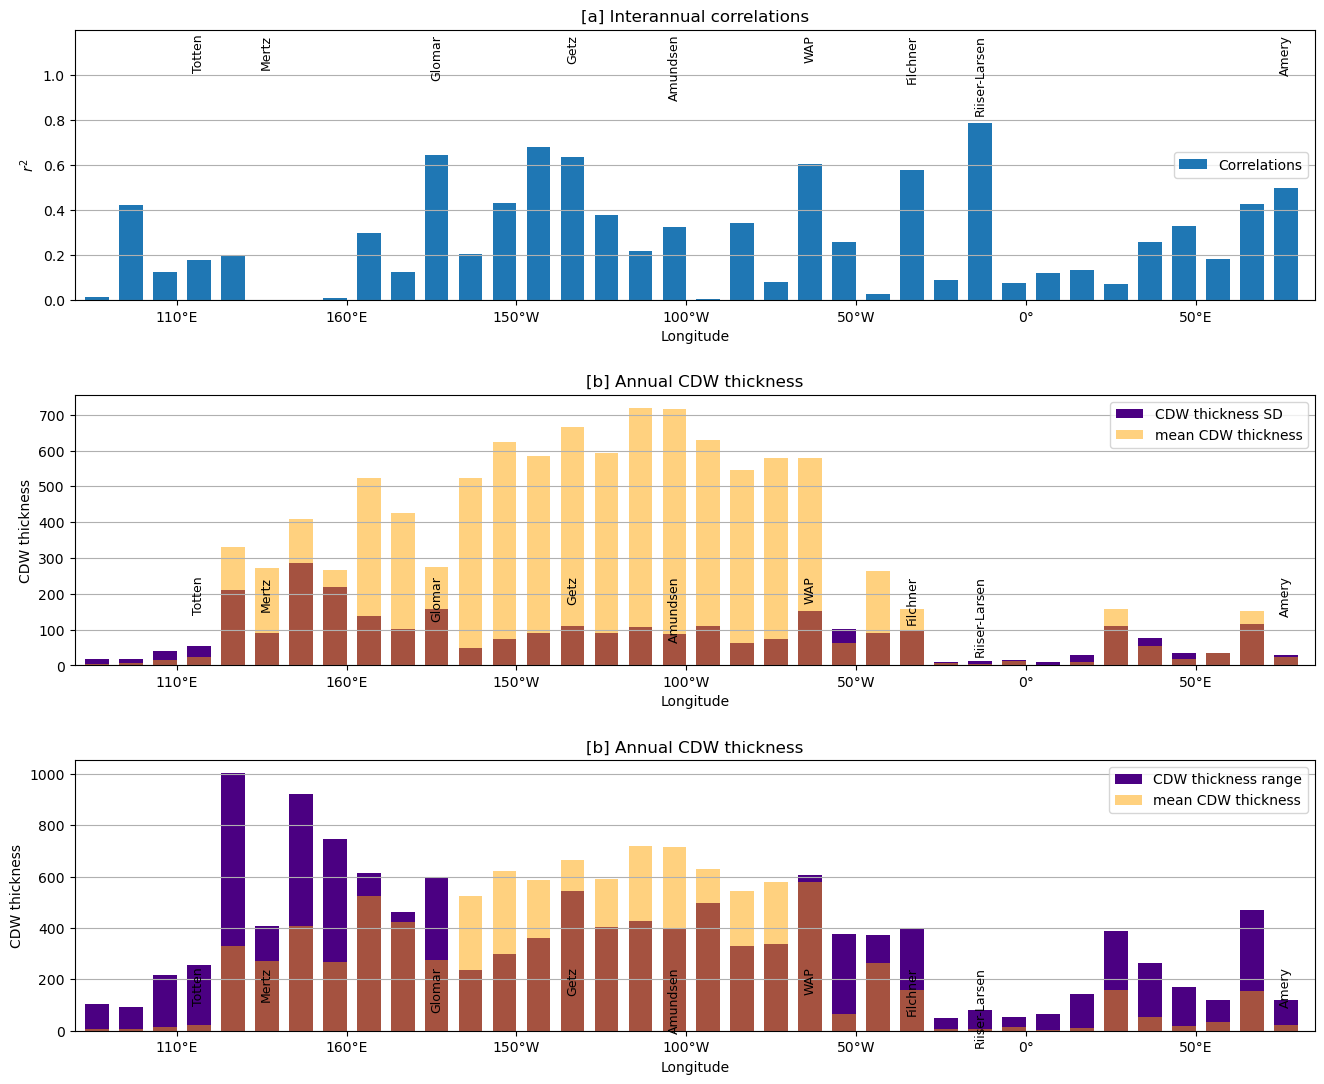

In [19]:
plt.figure(figsize=(16,13))
plt.subplots_adjust( hspace=.35)
#fig,ax_cric = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5))

ax_cric0 = plt.subplot(3,1,1)
#r_sq_annual_10deg.to_series().plot.bar(label='With zonal convergence')
plt.bar(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg,width=7,label='Correlations')
plt.legend()
plt.grid(axis='y')
plt.ylabel('$r^2$')
plt.ylim(0,1.2)
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 1.18, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.title('[a] Interannual correlations')
plt.yticks([0,.2,.4,.6,.8,1])
plt.xlim(-280,85)
ax_cric0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')

ax_cric1 = plt.subplot(3,1,2)
plt.bar(r_sq_annual_10deg.lon_bins,CDW_annual_std_thickness,width=7,label='CDW thickness SD',color='indigo')
plt.bar(r_sq_annual_10deg.lon_bins,CDW_annual_mean_thickness,width=7,label='mean CDW thickness',color='orange',alpha=0.5)
plt.legend()
plt.grid(axis='y')
plt.ylabel('CDW thickness')
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 250, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
ax_cric1.xaxis.set_major_formatter(LongitudeFormatter())
plt.title('[b] Annual CDW thickness')
plt.xlabel('Longitude')
plt.xlim(-280,85)


ax_cric2 = plt.subplot(3,1,3)
plt.bar(r_sq_annual_10deg.lon_bins,CDW_annual_range_thickness,width=7,label='CDW thickness range',color='indigo')
plt.bar(r_sq_annual_10deg.lon_bins,CDW_annual_mean_thickness,width=7,label='mean CDW thickness',color='orange',alpha=0.5)
plt.legend()
plt.grid(axis='y')
plt.ylabel('CDW thickness')
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 250, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
ax_cric2.xaxis.set_major_formatter(LongitudeFormatter())
plt.title('[b] Annual CDW thickness')
plt.xlabel('Longitude')
plt.xlim(-280,85)


I guess some of the regions we find high correlation do seem to have a range of CDW thickness similar to its mean state, which suggeses a large stretching and thinning of the layer. But that is definnetly not the only predictor. Likely another strong component would be the CDW temeprature at the isobath, which is not being taken into account here

### Testing line plots with different correlations

Extracting CDW temps along contour

In [32]:
import cosima_cookbook as cc

session = cc.database.create_session()

st_edges = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'st_edges_ocean', session,n=1)
st_ocean_val = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'st_ocean', session,n=1)


In [46]:
dzt = st_ocean_val.copy(data=np.array(st_edges.diff('st_edges_ocean')))
dzt.name='dzt'

In [200]:
#max_CDW_depth  - min_CDW_depth
CDW_temps_10_deg = T_iaf_monthly_along_contour_10_deg.where(T_iaf_monthly_along_contour_10_deg.st_ocean>=min_CDW_depth).\
where(T_iaf_monthly_along_contour_10_deg.st_ocean<=max_CDW_depth)
#CDW temp depth mean
CDW_mean_temps_10_deg = CDW_temps_10_deg.weighted(dzt).mean('st_ocean')
CDW_annualmean_sd_temps_10_deg = CDW_mean_temps_10_deg.groupby('time.year').mean().std('year')
CDW_annualmean_range_temps_10_deg = CDW_mean_temps_10_deg.groupby('time.year').mean().max('year') - CDW_mean_temps_10_deg.groupby('time.year').mean().min('year') 
#Standard deviaation of maximum temeprature at depth
CDW_maxdepth_STD_temps_10_deg = CDW_temps_10_deg.groupby('time.year').mean().max('st_ocean').std('year')
#range of maximum temeprature at depth
CDW_maxdepth_range_temps_10_deg = CDW_temps_10_deg.groupby('time.year').mean().max('st_ocean').max('year') - CDW_temps_10_deg.groupby('time.year').mean().max('st_ocean').min('year') 
#Standard deviaation of minimum temeprature at depth
CDW_mindepth_STD_temps_10_deg = CDW_temps_10_deg.groupby('time.year').mean().min('st_ocean').std('year')

Let's try a multivariate sort of analysis

In [174]:
annualmean_ASCspeed_CDW = (mean_u_CDW.groupby('time.year').mean().mean('year')**2)**0.5 #speed
annualmean_u_CDW = mean_u_CDW.groupby('time.year').mean().mean('year') #velocity
annualrange_u_CDW = mean_u_CDW.groupby('time.year').mean().max('year') - mean_u_CDW.groupby('time.year').mean().min('year')
annualSD_u_CDW = mean_u_CDW.groupby('time.year').mean().std('year') #standard deviation

In [224]:
import pandas as pd

# convert to DataFrame for easier stats
df = pd.DataFrame({
    "r_sq": r_sq_annual_10deg.values,
    "CDW temperature standard deviation": CDW_annualmean_sd_temps_10_deg.values,
    "CDW temperature range": CDW_annualmean_range_temps_10_deg.values,
    "CDW thickness Standard Deviation": CDW_annual_std_thickness.values,
    "CDW thickness range": CDW_annual_range_thickness.values,
    "CDW mean thickness": CDW_annual_mean_thickness.values,
    "CDW minimum depth standard deviation": SD_annualmin_CDW_depth.values,
    "CDW mean depth standard deviation": SD_annualmean_CDW_depth.values,
    "CDW range of minimum depth": range_annualmin_CDW_depth.values,
    "CDW range of mean depth": range_annualmean_CDW_depth.values,
    "Annual mean ASC speed": annualmean_ASCspeed_CDW.values,
    "Annual mean ASC velocity range": annualrange_u_CDW.values,
    "Annual mean ASC velocity standard deviation": annualSD_u_CDW.values,
    "Standard deviation of depth-maximum temperature": CDW_maxdepth_STD_temps_10_deg.values,
    "Standard deviation of depth-minimum temperature": CDW_mindepth_STD_temps_10_deg.values,
    "Range of depth-maximum temperature": CDW_maxdepth_range_temps_10_deg.values,
}, index=r_sq_annual_10deg.lon_bins.values)


In [225]:
corrs = (df.corr()["r_sq"]).sort_values(ascending=False)
print(corrs)

r_sq                                               1.000000
Standard deviation of depth-maximum temperature    0.382347
Range of depth-maximum temperature                 0.233057
CDW temperature standard deviation                 0.165678
CDW mean thickness                                 0.153570
CDW temperature range                              0.114064
Standard deviation of depth-minimum temperature    0.105388
Annual mean ASC velocity range                     0.098990
Annual mean ASC velocity standard deviation        0.070693
CDW thickness range                               -0.020685
CDW thickness Standard Deviation                  -0.059884
Annual mean ASC speed                             -0.100314
CDW range of mean depth                           -0.205863
CDW mean depth standard deviation                 -0.225548
CDW range of minimum depth                        -0.239394
CDW minimum depth standard deviation              -0.256777
Name: r_sq, dtype: float64


In [228]:
corrs = ((df.corr()["r_sq"]**2)**0.5).sort_values(ascending=False) #absulute value
print(corrs)

r_sq                                               1.000000
Standard deviation of depth-maximum temperature    0.382347
CDW minimum depth standard deviation               0.256777
CDW range of minimum depth                         0.239394
Range of depth-maximum temperature                 0.233057
CDW mean depth standard deviation                  0.225548
CDW range of mean depth                            0.205863
CDW temperature standard deviation                 0.165678
CDW mean thickness                                 0.153570
CDW temperature range                              0.114064
Standard deviation of depth-minimum temperature    0.105388
Annual mean ASC speed                              0.100314
Annual mean ASC velocity range                     0.098990
Annual mean ASC velocity standard deviation        0.070693
CDW thickness Standard Deviation                   0.059884
CDW thickness range                                0.020685
Name: r_sq, dtype: float64


Biggest predictor seem to be the standard deviation of Tmax(z), which probably mean that hot-spots of temperature was the best single feature explaining spatial variability of $r^2$


(0.08, 0.22)

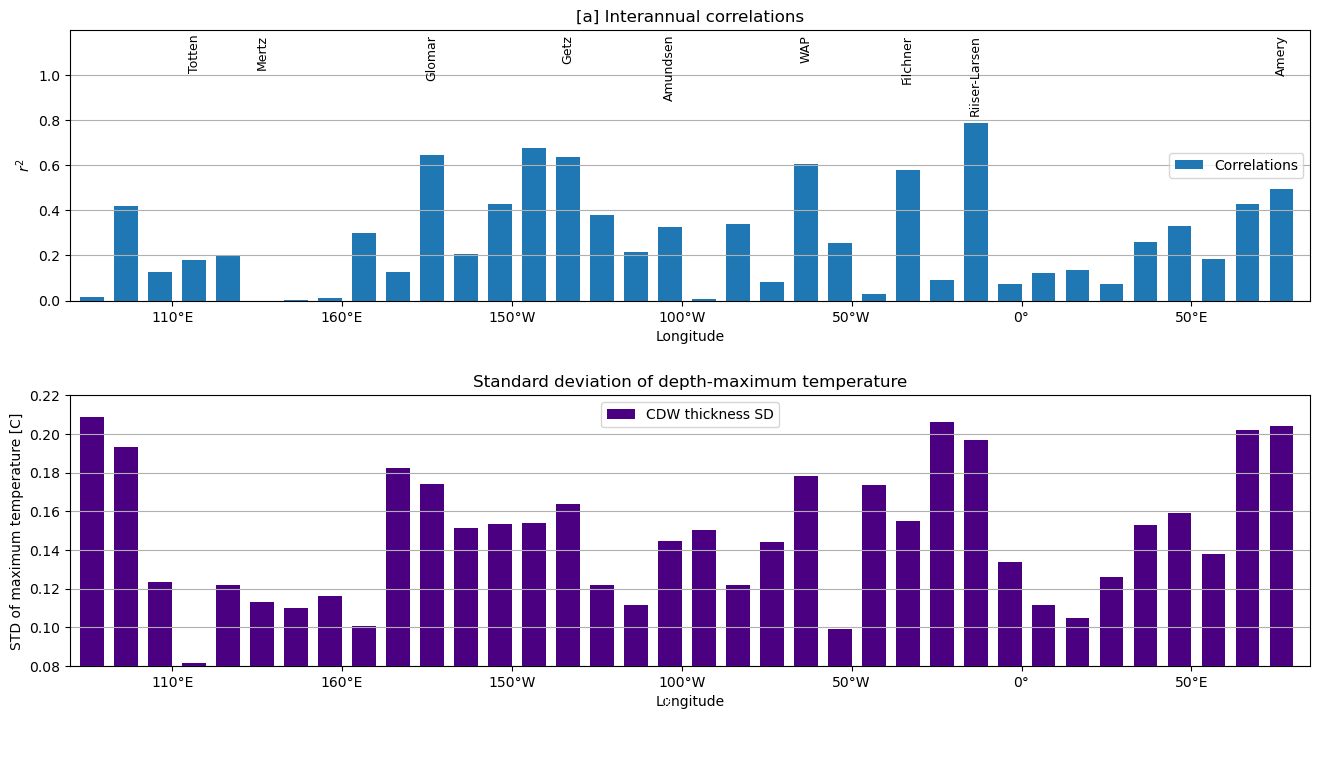

In [210]:
plt.figure(figsize=(16,13))
plt.subplots_adjust( hspace=.35)
#fig,ax_cric = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5))

ax_cric0 = plt.subplot(3,1,1)
#r_sq_annual_10deg.to_series().plot.bar(label='With zonal convergence')
plt.bar(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg,width=7,label='Correlations')
plt.legend()
plt.grid(axis='y')
plt.ylabel('$r^2$')
plt.ylim(0,1.2)
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 1.18, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.title('[a] Interannual correlations')
plt.yticks([0,.2,.4,.6,.8,1])
plt.xlim(-280,85)
ax_cric0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')

ax_cric1 = plt.subplot(3,1,2)
plt.bar(r_sq_annual_10deg.lon_bins,CDW_maxdepth_STD_temps_10_deg,width=7,label='CDW thickness SD',color='indigo')
plt.legend()
plt.grid(axis='y')
plt.ylabel('STD of maximum temperature [C]')
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 0.07, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='white')
ax_cric1.xaxis.set_major_formatter(LongitudeFormatter())
plt.title('Standard deviation of depth-maximum temperature')
plt.xlabel('Longitude')
plt.xlim(-280,85)
plt.ylim(0.08,0.22)



In [177]:
import statsmodels.api as sm

X = df.drop(columns=["r_sq"])  # predictors
y = df["r_sq"]

X = sm.add_constant(X)  # add intercept
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   r_sq   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.9471
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.531
Time:                        13:56:19   Log-Likelihood:                 12.415
No. Observations:                  36   AIC:                             5.170
Df Residuals:                      21   BIC:                             28.92
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [178]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=["r_sq"]))
lasso = LassoCV(cv=5).fit(X_scaled, y)

print("Selected predictors:", df.drop(columns=["r_sq"]).columns[lasso.coef_ != 0])

Selected predictors: Index(['Standard deviation of maximum(z) at depth'], dtype='object')
